---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

## Predicting the Future Direction of the Dow Jones Index

       date_x       GDP       CPI  Unemployment  FedFundsRate        M2  \
0  2000-01-01 -1.419333 -1.594756     -0.867414      1.754717 -1.259868   
1  2000-02-01 -1.371109 -1.576251     -0.816379      1.893549 -1.257353   
2  2000-03-01 -1.371109 -1.549815     -0.867414      1.953048 -1.251527   
3  2000-04-01 -1.371735 -1.552459     -0.969482      2.037339 -1.240917   
4  2000-05-01 -1.371109 -1.544528     -0.867414      2.161296 -1.243205   

    Umscent  real_estate   Exports   Imports  ...  MACD_Lag2_dow_jones  \
0  2.199732    -1.446673 -1.458048 -1.614811  ...           -65.554617   
1  2.146820    -1.436692 -1.391110 -1.523412  ...           -65.554617   
2  1.829348    -1.421047 -1.391110 -1.523412  ...           -65.554617   
3  1.988084    -1.402256 -1.395372 -1.552202  ...           -65.554617   
4  2.101467    -1.381961 -1.391110 -1.523412  ...           -65.554617   

   Close_Lag2_dow_jones  Volume_Lag2_dow_jones  RSI_Lag3_dow_jones  \
0          10090.900391           

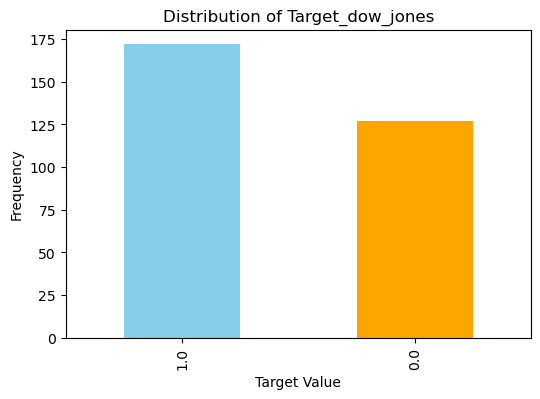

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Load the macro_data dataset
macro_data = pd.read_csv("../../data/processed-data/macro_data.csv")

# Display the first few rows to understand the structure
print(macro_data.head())

# Check the distribution of the target variable
target_counts = macro_data['Target_dow_jones'].value_counts()
print(target_counts)

# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Target_dow_jones')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns 
X = macro_data.drop(columns=['Target_dow_jones', 'date_x', 'date_y'], errors='ignore')
y = macro_data['Target_dow_jones']

# Ensure all remaining columns are numeric
X = X.select_dtypes(include=['float64', 'int64'])

# Fill missing values with the mean of each column
X = X.fillna(X.mean())

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Output the shape of the datasets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (239, 184)
Testing set shape: (60, 184)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save predictions into a DataFrame
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Define output directory
output_dir = "../../data/visualized-data"
os.makedirs(output_dir, exist_ok=True)


Model Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94        25
         1.0       0.94      0.97      0.96        35

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

Confusion Matrix:
[[23  2]
 [ 1 34]]


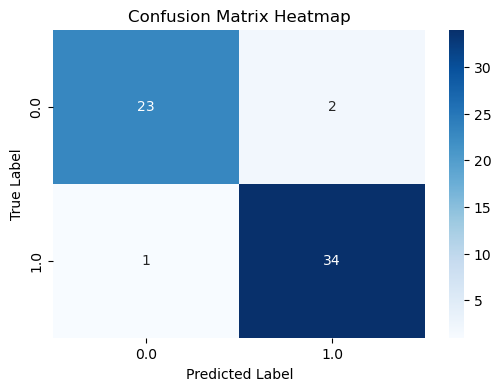

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


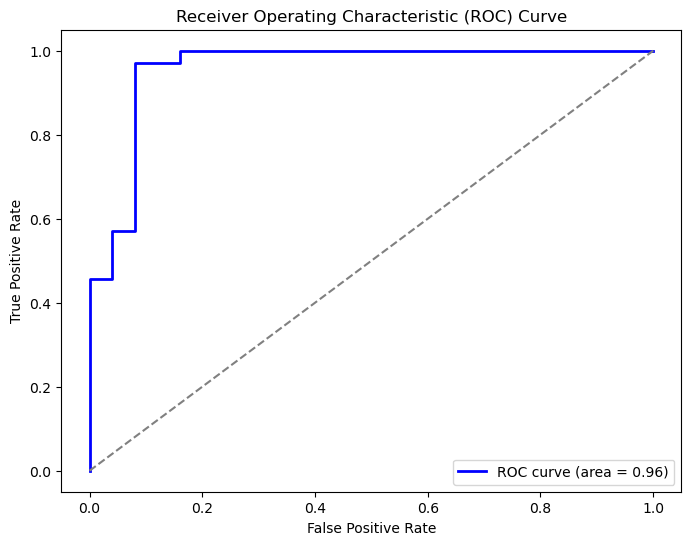

In [8]:
from sklearn.metrics import roc_curve, auc

# Compute probabilities and ROC curve
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1.0
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Predicting 5-Day Future Returns of the Dow Jones Index

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the merged_assets dataset
data = pd.read_csv("../../data/processed-data/merged_assets.csv")

# Feature selection: Choose relevant features for prediction
selected_features = ['Daily_Return_sp500', 'Volatility_sp500', 'MA_50_sp500', 'MA_200_sp500']
target = 'Future_Return_5D_dow_jones'

# Drop rows with missing values in selected features or target
data = data.dropna(subset=selected_features + [target])

# Split data into features (X) and target (y)
X = data[selected_features]
y = data[target]

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Linear Regression and Random Forest models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train Linear Regression model
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Train Random Forest model
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate both models
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print("Linear Regression:")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"R^2 Score: {r2_lr:.4f}\n")

print("Random Forest Regression:")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"R^2 Score: {r2_rf:.4f}")

Linear Regression:
Mean Squared Error (MSE): 0.0006
R^2 Score: -0.0070

Random Forest Regression:
Mean Squared Error (MSE): 0.0004
R^2 Score: 0.3629


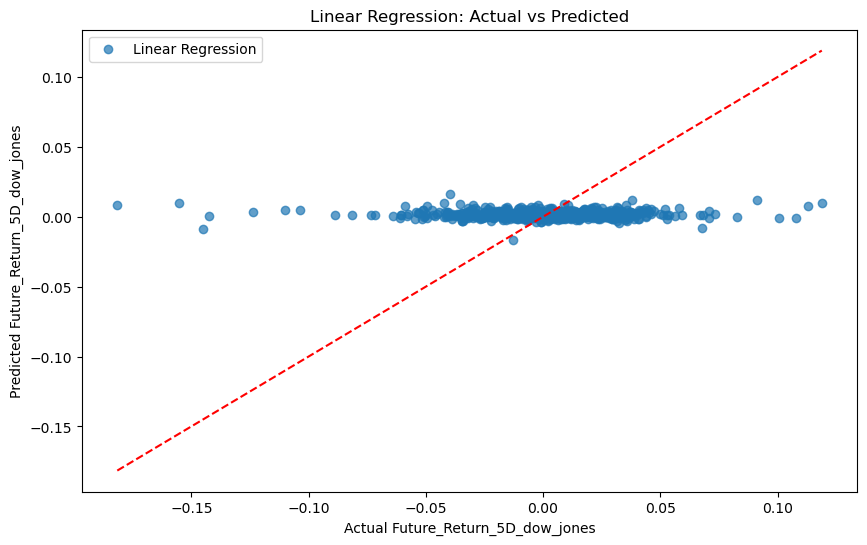

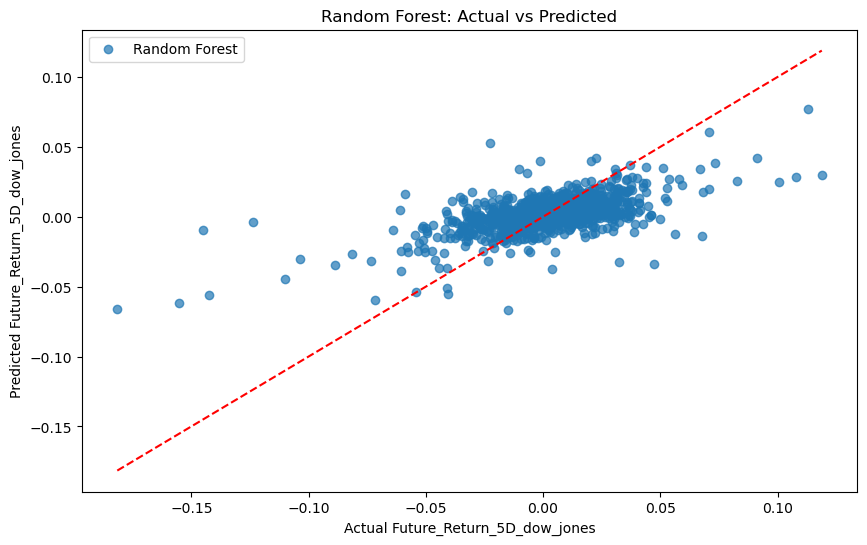

In [11]:
import matplotlib.pyplot as plt

# Scatter plot for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7, label="Linear Regression")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Future_Return_5D_dow_jones")
plt.ylabel("Predicted Future_Return_5D_dow_jones")
plt.legend()
plt.show()

# Scatter plot for Random Forest Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, label="Random Forest")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Future_Return_5D_dow_jones")
plt.ylabel("Predicted Future_Return_5D_dow_jones")
plt.legend()
plt.show()

In [12]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize XGBoost and LightGBM models
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42)

# Train XGBoost
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Train LightGBM
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Evaluate LightGBM
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# Print results
print("XGBoost Regression:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"R^2 Score: {r2_xgb:.4f}\n")

print("LightGBM Regression:")
print(f"Mean Squared Error (MSE): {mse_lgbm:.4f}")
print(f"R^2 Score: {r2_lgbm:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4670, number of used features: 4
[LightGBM] [Info] Start training from score 0.001494
XGBoost Regression:
Mean Squared Error (MSE): 0.0004
R^2 Score: 0.2709

LightGBM Regression:
Mean Squared Error (MSE): 0.0004
R^2 Score: 0.2653


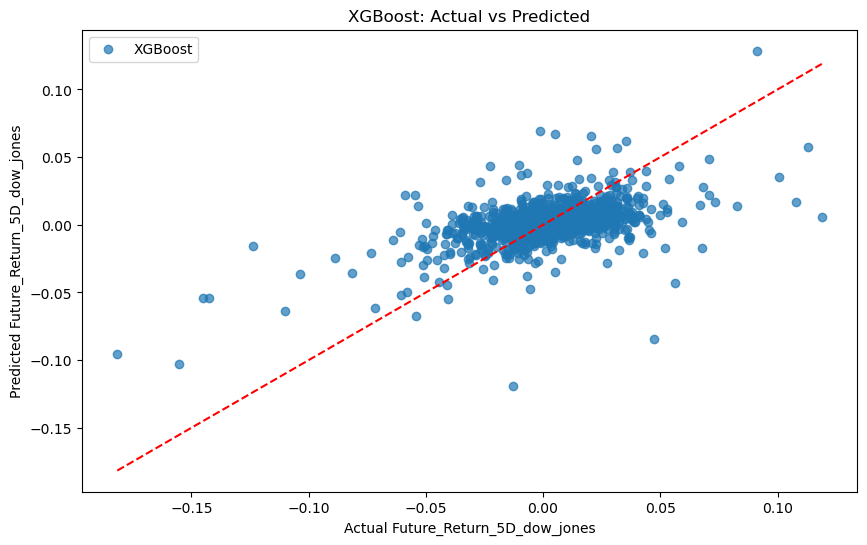

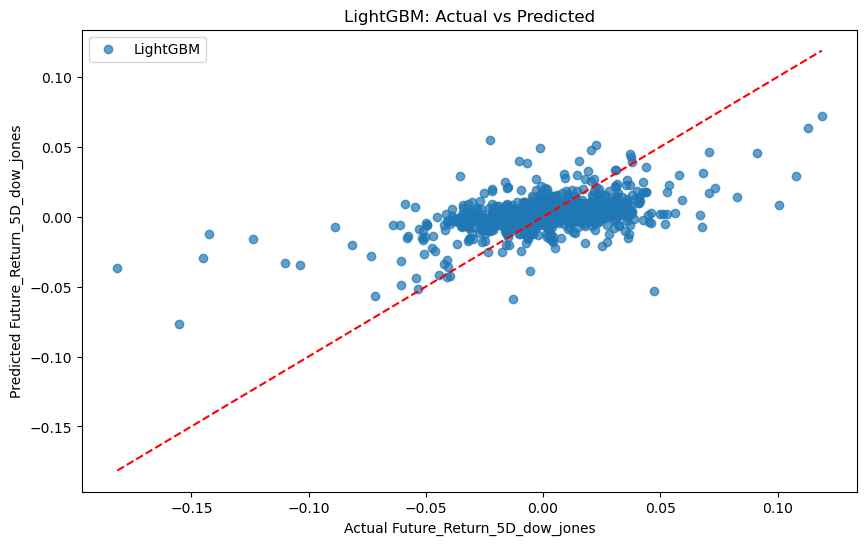

In [13]:
# Scatter plot for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7, label="XGBoost")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("XGBoost: Actual vs Predicted")
plt.xlabel("Actual Future_Return_5D_dow_jones")
plt.ylabel("Predicted Future_Return_5D_dow_jones")
plt.legend()
plt.show()

# Scatter plot for LightGBM
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.7, label="LightGBM")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("LightGBM: Actual vs Predicted")
plt.xlabel("Actual Future_Return_5D_dow_jones")
plt.ylabel("Predicted Future_Return_5D_dow_jones")
plt.legend()
plt.show()

In [14]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("../../data/processed-data/merged_assets.csv")

# Add lag features
data['Lag1_Return'] = data['Future_Return_5D_dow_jones'].shift(1)
data['Lag2_Return'] = data['Future_Return_5D_dow_jones'].shift(2)

# Add rolling mean and standard deviation
data['Rolling_Mean_5'] = data['Future_Return_5D_dow_jones'].rolling(window=5).mean()
data['Rolling_Std_5'] = data['Future_Return_5D_dow_jones'].rolling(window=5).std()

# Drop rows with NaN values caused by lag and rolling calculations
data = data.dropna()

# Display the first rows with new features
print(data[['Future_Return_5D_dow_jones', 'Lag1_Return', 'Lag2_Return', 'Rolling_Mean_5', 'Rolling_Std_5']].head())


   Future_Return_5D_dow_jones  Lag1_Return  Lag2_Return  Rolling_Mean_5  \
4                   -0.045420    -0.030264    -0.018099       -0.016608   
5                   -0.037069    -0.045420    -0.030264       -0.025229   
6                   -0.018466    -0.037069    -0.045420       -0.029863   
7                   -0.024781    -0.018466    -0.037069       -0.031200   
8                   -0.031627    -0.024781    -0.018466       -0.031473   

   Rolling_Std_5  
4       0.022281  
5       0.019495  
6       0.011857  
7       0.010499  
8       0.010486  


In [24]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Select features (including new lag and rolling features) and target
features = ['Daily_Return_sp500', 'Volatility_sp500', 'Lag1_Return', 'Lag2_Return', 'Rolling_Mean_5', 'Rolling_Std_5']
X = data[features]
y = data['Future_Return_5D_dow_jones']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost and LightGBM with optimized parameters
xgb_model = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=300, random_state=42)
lgbm_model = LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=300, random_state=42)

# Train XGBoost model
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Train LightGBM model
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Evaluate LightGBM
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# Print results
print("XGBoost Regression:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"R^2 Score: {r2_xgb:.4f}\n")

print("LightGBM Regression:")
print(f"Mean Squared Error (MSE): {mse_lgbm:.4f}")
print(f"R^2 Score: {r2_lgbm:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 6
[LightGBM] [Info] Start training from score 0.001702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

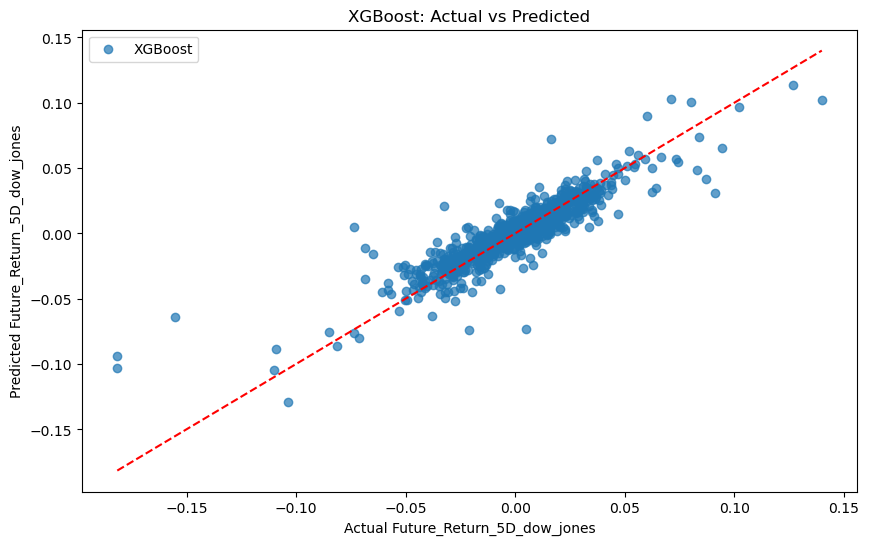

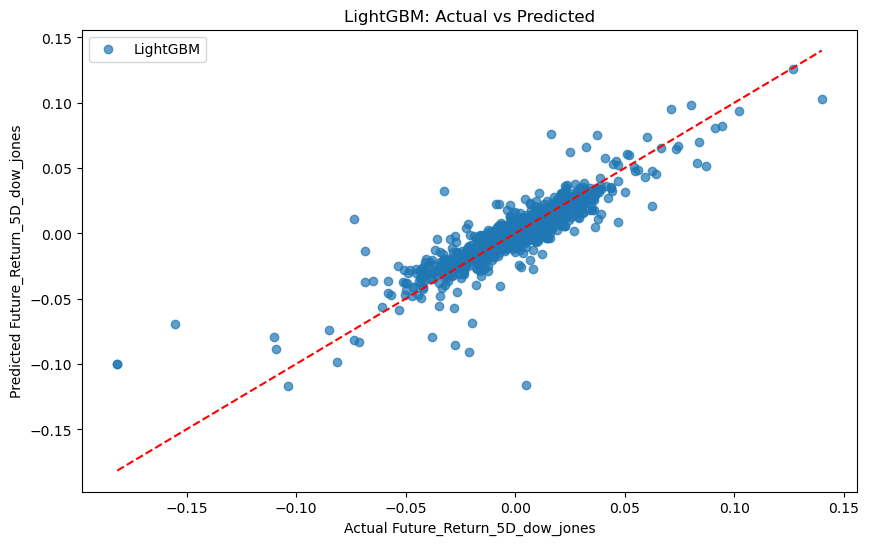

In [25]:
import matplotlib.pyplot as plt

# Plot for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7, label="XGBoost")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("XGBoost: Actual vs Predicted")
plt.xlabel("Actual Future_Return_5D_dow_jones")
plt.ylabel("Predicted Future_Return_5D_dow_jones")
plt.legend()
plt.show()

# Plot for LightGBM
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.7, label="LightGBM")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("LightGBM: Actual vs Predicted")
plt.xlabel("Actual Future_Return_5D_dow_jones")
plt.ylabel("Predicted Future_Return_5D_dow_jones")
plt.legend()
plt.show()

In [26]:
# Get the latest data
latest_data = data.iloc[-1]

# Create the feature vector
latest_features = [
    latest_data['Daily_Return_sp500'],
    latest_data['Volatility_sp500'],
    latest_data['Lag1_Return'],
    latest_data['Lag2_Return'],
    latest_data['Rolling_Mean_5'],
    latest_data['Rolling_Std_5']
]

# Use the model to make the prediction
future_price = lgbm_model.predict([latest_features])

# Analyze the prediction
if future_price[0] > data['Close_dow_jones'].iloc[-1]:
    print('Predicted future price will increase')
else:
    print('Predicted future price will decrease')

Predicted future price will decrease


{{< include summary.qmd >}} 